In [1]:
import sqlite3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import os

In [2]:
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
c = conn.cursor()

In [3]:
c.execute('SELECT * FROM journeys')
df = gpd.GeoDataFrame(c.fetchall(), columns=['id', 'total_duration', 'start_datetime', 'end_datetime', 'gec', 'nox_pm', 'duration_per_method', 'distance_per_method', 'path'])
df['gec'] = df['gec'].apply(lambda x: json.loads(x))
df['nox_pm'] = df['nox_pm'].apply(lambda x: json.loads(x))
df['duration_per_method'] = df['duration_per_method'].apply(lambda x: json.loads(x))
df['distance_per_method'] = df['distance_per_method'].apply(lambda x: json.loads(x))
df['path'] = df['path'].apply(lambda x: json.loads(x))
df.head()

,id,total_duration,start_datetime,end_datetime,gec,nox_pm,duration_per_method,distance_per_method,path
0,1,2972,20240525T175138,20240525T184110,"{'value': 933.1212, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2972, 'walking': 1232, 'bike': 0, 'c...","{'walking': 272, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Liberté', 'arrival_date_time'..."
1,2,2636,20240525T173733,20240525T182129,"{'value': 380.232, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2636, 'walking': 1436, 'bike': 0, 'c...","{'walking': 612, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Pont de La Mulatière', 'arriv..."
2,3,3025,20240525T174745,20240525T183810,"{'value': 558.0722, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3025, 'walking': 1945, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."
3,4,3685,20240525T174745,20240525T184910,"{'value': 726.4134, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1585, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."
4,5,3685,20240525T174745,20240525T184910,"{'value': 705.801, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1525, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."


In [4]:
c.execute('SELECT * FROM stops')
stops_df = gpd.GeoDataFrame(c.fetchall(), columns=['stop_id', 'stop_name', 'lon_lat', 'accessibility'])
stops_df['lon_lat'] = stops_df['lon_lat'].apply(lambda x: json.loads(x))
stops_df.head()

,stop_id,stop_name,lon_lat,accessibility
0,stop_point:tcl:SP:32113,Liberté,"{'lon': '4.842381', 'lat': '45.758852'}","[""has_wheelchair_boarding""]"
1,stop_point:tcl:SP:32111,Guillotière Gabriel Péri,"{'lon': '4.842434', 'lat': '45.754935'}","[""has_wheelchair_boarding""]"
2,stop_point:tcl:SP:30200,Guillotière Gabriel Péri,"{'lon': '4.84252', 'lat': '45.75541'}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
3,stop_point:tcl:SP:30202,Bellecour,"{'lon': '4.833822', 'lat': '45.756711'}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
4,stop_point:tcl:SP:45799,Bellecour Le Viste,"{'lon': '4.833739', 'lat': '45.757154'}","[""has_wheelchair_boarding""]"


In [5]:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# returns the distance in meters
def coord_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """
        Given two coordinates, returns the distance between them in meters.
        Args:
            lat1 (float): latitude of the first point
            lon1 (float): longitude of the first point
            lat2 (float): latitude of the second point
            lon2 (float): longitude of the second point
            
        Returns:
            float: distance between the two points in meters
        """
        R = 6371e3
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        d = R * c
        return d
    
# if the distance.csv file already exists, use that instead
if os.path.isfile('distance.csv'):
    print('Journey distance file already exists, using that instead')
    df['distance'] = pd.read_csv('distance.csv')['distance']
    
# otherwise, calculate the distance for each journey
else:
    print('Calculating journey distances')
    # calculate the distance of each journey
    
    try:
        distances = []
        n = 0
        done = len(df)
        start_time = time.time()
        
        # I was running into an error where a stop in the path was not in the stops dataframe, so I added this check to remove any stops that are not in the stops dataframe
        # This means that the path may not be as accurate, but it's better than having an error
        # do all the stops in the path exist in the stops dataframe?
        # if not, remove them
        print('Checking if all stops in the path exist in the stops dataframe')
        for i, row in df.iterrows():
            path = df['path'][i]
            new_path = []
            for stop in path:
                if stop['stop_point'] in stops_df['stop_name'].values:
                    new_path.append(stop)
            df.at[i, 'path'] = new_path
            n += 1
            # print percentage done and time taken
            if n % 10000 == 0:
                print(f'{n}/{done} ({n/done*100:.2f}%)')
                print(f'{(done-n)/n*(time.time()-start_time)/60:.2f} minutes remaining')
        
        # calculate the distance of each journey
        print('--' * 20)
        print('Calculating distances')
        n = 0
        start_time = time.time()
        for i, row in df.iterrows():
            path = row['path']
            distance = 0
            for i in range(len(path) - 1):
                start = path[i]['stop_point']
                end = path[i+1]['stop_point']
                
                start_coords = stops_df[stops_df['stop_name'] == start]['lon_lat'].values[0]
                end_coords = stops_df[stops_df['stop_name'] == end]['lon_lat'].values[0]
                distance += coord_distance(float(start_coords['lon']), float(start_coords['lat']), float(end_coords['lon']), float(end_coords['lat']))
            distances.append(distance)
            n += 1
            # print percentage done and time taken
            if n % 10000 == 0:
                print(f'{n}/{done} ({n/done*100:.2f}%)')
                print(f'{(done-n)/n*(time.time()-start_time)/60:.2f} minutes remaining')
        df['distance'] = distances

        # save the data to a csv so I never have to do this again
        df['distance'].to_csv('distance.csv')
    except IndexError as e:
        print(f'Error at index {i}')
        print(f'Start: {start}, End: {end}')
        print(f'Start coords: {start_coords}, End coords: {end_coords}')
        raise e

Journey distance file already exists, using that instead


In [6]:
df.head()

,id,total_duration,start_datetime,end_datetime,gec,nox_pm,duration_per_method,distance_per_method,path,distance
0,1,2972,20240525T175138,20240525T184110,"{'value': 933.1212, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2972, 'walking': 1232, 'bike': 0, 'c...","{'walking': 272, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Liberté', 'arrival_date_time'...",7230.325009
1,2,2636,20240525T173733,20240525T182129,"{'value': 380.232, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2636, 'walking': 1436, 'bike': 0, 'c...","{'walking': 612, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Pont de La Mulatière', 'arriv...",9124.219471
2,3,3025,20240525T174745,20240525T183810,"{'value': 558.0722, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3025, 'walking': 1945, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7287.909338
3,4,3685,20240525T174745,20240525T184910,"{'value': 726.4134, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1585, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7085.043248
4,5,3685,20240525T174745,20240525T184910,"{'value': 705.801, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1525, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",6733.550704


In [7]:
# remove rows that are outliers in terms of total_duration
q1 = df['total_duration'].quantile(0.25)
q3 = df['total_duration'].quantile(0.75)
iqr = q3 - q1
df = df[(df['total_duration'] > (q1 - 1.5 * iqr)) & (df['total_duration'] < (q3 + 1.5 * iqr))]

# remove rows that are outliers in terms of distance
q1 = df['distance'].quantile(0.25)
q3 = df['distance'].quantile(0.75)
iqr = q3 - q1
df = df[(df['distance'] > (q1 - 1.5 * iqr)) & (df['distance'] < (q3 + 1.5 * iqr))]

# remove rows that are outliers in terms of gec
q1 = df['gec'].apply(lambda x: x['value']).quantile(0.25)
q3 = df['gec'].apply(lambda x: x['value']).quantile(0.75)
iqr = q3 - q1
df = df[(df['gec'].apply(lambda x: x['value']) > (q1 - 1.5 * iqr)) & (df['gec'].apply(lambda x: x['value']) < (q3 + 1.5 * iqr))]

# convert distance to km
df['distance'] = df['distance'] / 1000

# gEC per km
df['gec'] = df['gec'].apply(lambda x: x['value'])
df['gec_per_km'] = df['gec'] / df['distance']

# remove rows that are outliers in terms of gec_per_km
q1 = df['gec_per_km'].quantile(0.25)
q3 = df['gec_per_km'].quantile(0.75)
iqr = q3 - q1
df = df[(df['gec_per_km'] > (q1 - 1.5 * iqr)) & (df['gec_per_km'] < (q3 + 1.5 * iqr))]

In [8]:
# print(df['distance'].describe())
df['distance'].hist(bins=100, grid=False)
plt.title('Distribution of journey distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.savefig('out/gec/distance_hist.png')
plt.close()

In [9]:
print('gEC mean:', np.mean(df['gec']))
print('gEC median:', np.median(df['gec']))
print('gEC std:', np.std(df['gec']))
print('-----------------')
print('gEC per km mean:', np.mean(df['gec_per_km']))
print('gEC per km median:', np.median(df['gec_per_km']))
print('gEC per km std:', np.std(df['gec_per_km']))

gEC mean: 636.4138440696621
gEC median: 591.1401
gEC std: 392.3039067944804
-----------------
gEC per km mean: 83.35484499190709
gEC per km median: 85.96349852268031
gEC per km std: 45.31102243891829


In [10]:
# boxplot of gEC per km
df['gec_per_km'].plot(kind='box')
plt.ylabel('gEC per km')
plt.title('gEC per km boxplot')
plt.xticks([])
plt.close()

In [11]:
# plot gEC vs total_duration
plt.scatter(df['total_duration'], df['gec'], alpha=0.5, s=10)
plt.xlabel('Total Trip Duration')
plt.ylabel('gEC')
plt.title('gEC vs Total Trip Duration')

# trendline with correlation coefficient
z = np.polyfit(df['total_duration'], df['gec'], 1)
p = np.poly1d(z)
plt.plot(df['total_duration'],p(df['total_duration']),"r--")
plt.xlim(500, 6500)
plt.savefig('out/gec/gEC_vs_total_duration.png')
print('Correlation coefficient:', round(np.corrcoef(df['total_duration'], df['gec'])[0, 1], 3))
print('Equation of trendline:', p)
plt.close()

Correlation coefficient: 0.691
Equation of trendline:  
0.2638 x - 275.8


In [12]:
# gEC vs distance
plt.scatter(df['distance'], df['gec'], alpha=0.5, s=10)
plt.xlabel('Distance (km)')
plt.ylabel('gEC')
plt.title('gEC vs Distance')

# trendline with correlation coefficient
z = np.polyfit(df['distance'], df['gec'], 1)
p = np.poly1d(z)
plt.plot(df['distance'],p(df['distance']),"r--")
print('Correlation coefficient:', round(np.corrcoef(df['distance'], df['gec'])[0, 1], 3))
print('Equation of trendline:', p)
plt.xlim(0, 20)
plt.savefig('out/gec/gEC_vs_distance.png')
plt.close()

Correlation coefficient: 0.436
Equation of trendline:  
47.87 x + 244.4


In [13]:
# histogram of gEC
plt.clf()
plt.hist(df['gec'], bins=50)
plt.xlabel('gEC')
plt.xlim(0, 1750)
plt.ylabel('Frequency')
plt.title('Histogram of gEC')
plt.savefig('out/gec/histogram_of_gEC.png')
plt.close()

In [14]:
# average gEC per hour of day
avg_gec = []
for i in range(5, 24):
    avg_gec.append(np.mean(df[df['start_datetime'].str.contains(f'T{i:02}')]['gec']))
    
plt.plot(range(5, 24), avg_gec, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average gEC')
plt.ylim(0, 1000)
plt.title('Average gEC per Hour of Day')
plt.savefig('out/gec/avg_gEC_per_hour_of_day.png')
plt.close()

### The average car's gEC/km is around 166-170 per km.
#### sources:
- https://ourworldindata.org/travel-carbon-footprint
- https://www.transilien.com/en/page-corporate/calcul-emissions-co2
- https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2022

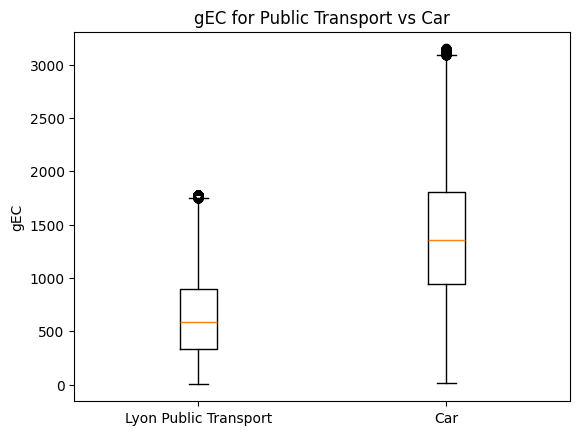

In [15]:
# boxplot comparing gEC per km for different methods
CAR_GEC = 170
df['gec_car'] = df['distance'] * CAR_GEC

plt.boxplot([df['gec'], df['gec_car']], labels=['Lyon Public Transport', 'Car'])
plt.ylabel('gEC')
plt.title('gEC for Public Transport vs Car')
plt.savefig('out/gec/gEC_per_km_for_public_transport_vs_car.png')
plt.show()

In [16]:
EU_GOAL = 95.0

df['gec_goal'] = df['distance'] * EU_GOAL

plt.boxplot([df['gec'], df['gec_goal']], labels=['Public Transport', 'EU Goal'])
plt.ylabel('gEC')
plt.title('gEC for Public Transport vs EU Goal')
plt.savefig('out/gec/gEC_per_km_for_public_transport_vs_eu_goal.png')
plt.close()

In [17]:
# dump the data to a csv
if not os.path.exists('out/journeys.csv'):
    df.to_csv('out/journeys.csv', index=False)

In [18]:
# two-sample t-test with random sqrt(n) samples
import scipy.stats as stats
import random

random.seed(42)
n = int(np.sqrt(len(df)))
public_transport = random.sample(list(df['gec']), n)
car = random.sample(list(df['gec_car']), n)

# check if the variances are equal
print('Levene test')
f_val, p_val = stats.levene(public_transport, car)
print('F-value:', f_val)
print('p-value:', p_val)
# if p-value is less than 0.05, variances are not equal
# if variances are not equal, use Welch's t-test
if p_val < 0.01:
    print('Variances are not equal')
    print()
    print('Welch\'s t-test')
    t_stat, p_val = stats.ttest_ind(public_transport, car, equal_var=False)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)
else:
    print('Variances are equal')
    print()
    print('T-test')
    t_stat, p_val = stats.ttest_ind(public_transport, car)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)

Levene test
F-value: 138.43174306072305
p-value: 1.5949749132090505e-30
Variances are not equal

Welch's t-test
t-statistic: -27.542861446667967
p-value: 5.986266981046135e-129


In [19]:
# two-sample t-test with random sqrt(n) samples between public transport and EU goal
n = int(np.sqrt(len(df)))
public_transport = random.sample(list(df['gec']), n)
eu_goal = random.sample(list(df['gec_goal']), n)

# check if the variances are equal
print('Levene test')
f_val, p_val = stats.levene(public_transport, eu_goal)
print('F-value:', f_val)
print('p-value:', p_val)
# if p-value is less than 0.01, variances are not equal
# if variances are not equal, use Welch's t-test
if p_val < 0.01:
    print('Variances are not equal')
    print()
    print('Welch\'s t-test')
    t_stat, p_val = stats.ttest_ind(public_transport, eu_goal, equal_var=False)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)
else:
    print('Variances are equal')
    print()
    print('T-test')
    t_stat, p_val = stats.ttest_ind(public_transport, eu_goal)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)

Levene test
F-value: 31.595273210062363
p-value: 2.2946633860161312e-08
Variances are not equal

Welch's t-test
t-statistic: -5.0933891375417835
p-value: 4.026306046630545e-07


In [20]:
# ttest between car and eu goal
n = int(np.sqrt(len(df)))
car = random.sample(list(df['gec_car']), 100)
eu_goal = random.sample(list(df['gec_goal']), 100)

# check if the variances are equal
print('Levene test')
f_val, p_val = stats.levene(car, eu_goal)
print('F-value:', f_val)
print('p-value:', p_val)
# if p-value is less than 0.01, variances are not equal
# if variances are not equal, use Welch's t-test
if p_val < 0.01:
    print('Variances are not equal')
    print()
    print('Welch\'s t-test')
    t_stat, p_val = stats.ttest_ind(car, eu_goal, equal_var=False)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)
else:
    print('Variances are equal')
    print()
    print('T-test')
    t_stat, p_val = stats.ttest_ind(car, eu_goal)
    print('t-statistic:', t_stat)
    print('p-value:', p_val)
    

Levene test
F-value: 36.80782216685253
p-value: 6.512763974266839e-09
Variances are not equal

Welch's t-test
t-statistic: 8.188676099537442
p-value: 9.402741385662451e-14


In [21]:
# shapiro-wilk test for normality
print('Shapiro-Wilk test')
print('Public Transport:', stats.shapiro(public_transport))
print('Car:', stats.shapiro(car))
print('EU Goal:', stats.shapiro(eu_goal))

Shapiro-Wilk test
Public Transport: ShapiroResult(statistic=0.9632681135126399, pvalue=3.861159032692445e-12)
Car: ShapiroResult(statistic=0.9789039729232476, pvalue=0.1091645357138959)
EU Goal: ShapiroResult(statistic=0.9852927948016472, pvalue=0.33333899522250465)


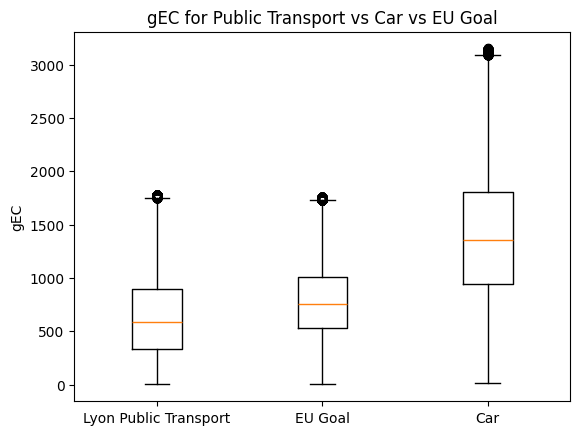

In [22]:
# boxplot of public transport vs car vs eu goal
plt.boxplot([df['gec'], df['gec_goal'], df['gec_car']], labels=['Lyon Public Transport', 'EU Goal', 'Car'])
plt.ylabel('gEC')
plt.title('gEC for Public Transport vs Car vs EU Goal')
plt.savefig('out/gec/gEC_per_km_for_public_transport_vs_car_vs_eu_goal.png')
plt.show()

In [23]:
# total average gEC between public transport and car
total = round((df['gec'].sum() + df['gec_car'].sum()) / (len(df) * 2), 2)
print('Average gEC (only public transit):', df['gec'].mean())
print('Average gEC (only cars):', df['gec_car'].mean())
print('Average gEC (including cars):', total)
print('Average gEC/km (only public transit)', df['gec'].mean()/df['distance'].mean())
print('Average gEC/km (only cars)', df['gec_car'].mean()/df['distance'].mean())
print('Average gEC/km (including cars)', total/df['distance'].mean())
print()
print(df['distance'].mean())

Average gEC (only public transit): 636.4138440696621
Average gEC (only cars): 1391.9197526294568
Average gEC (including cars): 1014.17
Average gEC/km (only public transit) 77.72743600158101
Average gEC/km (only cars) 170.0
Average gEC/km (including cars) 123.86410902949304

8.18776325076151


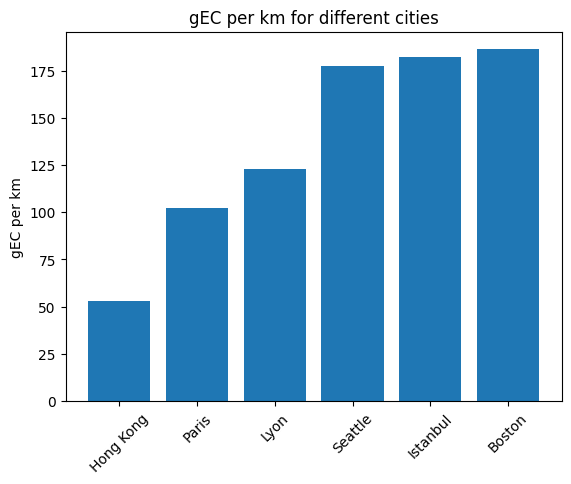

In [24]:
seattle_gec_km = 177.23
boston_gec_km = 186.3
paris_gec_km = 102.41
istanbul_gec_km = 182
hong_kong_gec_km = 53.07
lyon_gec_km = 122.63

cities = {
    'Seattle': seattle_gec_km,
    'Boston': boston_gec_km,
    'Paris': paris_gec_km,
    'Istanbul': istanbul_gec_km,
    'Hong Kong': hong_kong_gec_km,
    'Lyon': lyon_gec_km
}
# sort the cities by gEC per km
cities = dict(sorted(cities.items(), key=lambda x: x[1]))

# barchart of gEC per km for different cities in ascending order
plt.bar(cities.keys(), cities.values())
plt.xticks(rotation=45)
plt.ylabel('gEC per km')
plt.title('gEC per km for different cities')
plt.savefig('out/gec/gEC_per_km_for_different_cities.png', bbox_inches='tight')
plt.show()

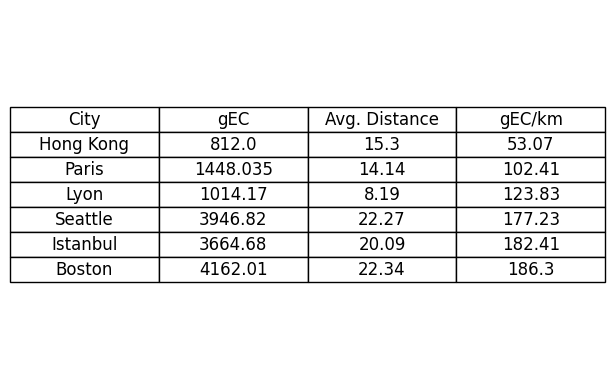

In [25]:
# create a table to display the data like Tahar wanted
seattle_gec = 7893.64 / 2
seattle_avg_dist = 22.27
seattle_gec_km = round(seattle_gec / seattle_avg_dist, 2)

boston_gec = 8324.02 / 2
boston_avg_dist = 22.34
boston_gec_km = round(boston_gec / boston_avg_dist, 2)

paris_gec = 2896.07 / 2
paris_avg_dist = 14.14
paris_gec_km = round(paris_gec / paris_avg_dist, 2)

istanbul_gec = 7329.36 / 2
istanbul_avg_dist = 20.09
istanbul_gec_km = round(istanbul_gec / istanbul_avg_dist, 2)

hk_gec = 1624 / 2
hk_avg_dist = 15.3
hk_gec_km = round(hk_gec / hk_avg_dist, 2)

lyon_gec = total
lyon_avg_dist = round(df['distance'].mean(), 2)
lyon_gec_km = round(lyon_gec / lyon_avg_dist, 2)

fig, ax = plt.subplots()
ax.axis('off')
table_data = [
    ["City", "gEC", "Avg. Distance", "gEC/km"],
    ["Hong Kong", hk_gec, hk_avg_dist, hk_gec_km],
    ["Paris", paris_gec, paris_avg_dist, paris_gec_km],
    ["Lyon", lyon_gec, lyon_avg_dist, lyon_gec_km],
    ["Seattle", seattle_gec, seattle_avg_dist, seattle_gec_km],
    ["Istanbul", istanbul_gec, istanbul_avg_dist, istanbul_gec_km],
    ["Boston", boston_gec, boston_avg_dist, boston_gec_km]
]

table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)
plt.show()

In [26]:
# gEC per km as a percent of Lyon for different cities
cities = {
    'Seattle': seattle_gec_km,
    'Boston': boston_gec_km,
    'Paris': paris_gec_km,
    'Istanbul': istanbul_gec_km,
    'Hong Kong': hong_kong_gec_km,
    'Lyon': lyon_gec_km
}

print('gEC per km as a percent of Lyon')
for city, gec in cities.items():
    print(f'{city}: {round(gec/lyon_gec_km*100, 2)}%')
    


gEC per km as a percent of Lyon
Seattle: 143.12%
Boston: 150.45%
Paris: 82.7%
Istanbul: 147.31%
Hong Kong: 42.86%
Lyon: 100.0%
